# Symbol prediction

Symbol prediction notebook

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [913]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys

import tensorflow as tf
from tensorflow.keras.preprocessing.image import smart_resize


from IPython.display import display, Latex


In [914]:
import resolve_symbols
from importlib import reload  # Python 3.4+

reload(resolve_symbols) #debugging
from resolve_symbols import remove_box_inside_box, create_merged_boxes, determine_box_level, merge_dots, sub_or_superscript_level, isolate_symbols_and_square, resolve_symbols_on_img


Load in class labels from class_names.txt 

In [915]:
with open('../class_names.txt', 'r') as f:
    lines = f.readlines()
class_labels = [label.split(' ')[-1][:-1] for label in lines]

In [916]:
efficientnet_model = tf.keras.models.load_model('../CNN_model/efficientnet_model.h5')

In [917]:
full_eq_imgs = glob.glob('../img_data/full_equations/*png')

In [918]:
img_idx = 146

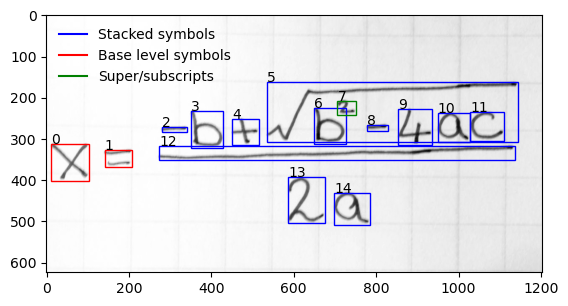

In [919]:
#symbs, levels, stack, script_levels, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])
symbs, levels, stack, script_levels, ax = resolve_symbols_on_img('../test_math.png')

In [929]:
pred_symbol_list = make_predictions(symbs)

1/1 [==============================] - 0s 27ms/step
{'t': 0.0001925737, 'capital_T': 0.0002805099, '\\sqrt': 0.0023226098, '-': 0.9965186}


In [922]:
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels)

<IPython.core.display.Latex object>

In [923]:
eqstr

'$\\times = \\frac{ -  b  +  -  b^{ 2}  -  4  a  c}{ 2  a}$'

Text(100, 420, '$\\times = \\frac{ -  b  +  -  b^{ 2}  -  4  a  c}{ 2  a}$')

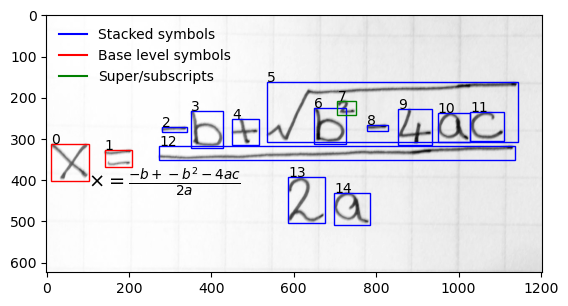

In [924]:
#symbs, levels, stack, script_levels, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])
symbs, levels, stack, script_levels, ax = resolve_symbols_on_img('../test_math.png')
add_y = 0
for i, symbol in enumerate(pred_symbol_list):
    #ax.text(75+add_y, 450, symbol[6:])
    add_y += 15 + (7*len(symbol[6:]))

ax.text(100, 420, eqstr, fontsize=14)

In [928]:
def make_predictions(symbol_list):

    pred_list = []
    pred_symbol_list, pred_idx_list = [], []
    for i, symbol in enumerate(symbs):
        rgb_im = np.zeros((symbol.shape[0], symbol.shape[1], 3))
        for i in range(3):
            rgb_im[:,:,i] = symbol.astype('uint8')
        resize_img = smart_resize(rgb_im, (100,100))
        resize_img = np.expand_dims(resize_img, axis=0)
        prediction = efficientnet_model.predict(resize_img)
    
        pred_dic = {k[6:]:v for v,k in sorted(zip(prediction[0], class_labels))[-4:]}
        y_classes = prediction.argmax(axis=-1)
        pred_idx_list.append(y_classes)
        pred_symbol_list.append(class_labels[y_classes[0]][6:])
        pred_list.append(pred_dic)
    print(pred_list[5])
    return pred_symbol_list

In [700]:
def turn_into_stack_LOLs(symbol_list, levels, stack, script_levels):
    """
    Turn the list of symbols, and script levels into list of lists
    Where each list only contains those entries that are at the same level
    """
    
    l_a = np.array(levels)
    level_lens = [0] +  [len(l_a[l_a==x]) for x in rangae(max(l_a)+1)]
    level_cum_lens = np.cumsum(level_lens)
    
    symbol_lol = [symbol_list[x_1:x_2] for x_1,x_2 in zip(level_cum_lens[:-1], level_cum_lens[1:])]
    script_lol = [script_levels[x_1:x_2] for x_1,x_2 in zip(level_cum_lens[:-1], level_cum_lens[1:])]
    
    #not lists of lists, just single entries for the stack/level of that list of symbols
    level_lol = [levels[x_1] for x_1,x_2 in zip(level_cum_lens[:-1], level_cum_lens[1:])]
    stack_lol = [stack[x_1] for x_1,x_2 in zip(level_cum_lens[:-1], level_cum_lens[1:])]
    
    return symbol_lol, level_lol, stack_lol, script_lol

In [787]:
def check_comb_signs(symbol_list, script_list):
    """
    Given a list of symbols, check whether there are subsequent symbols that should be interpreted as a single symbol
    SO FAR: checking for sin, cos, tan, log
    """
    
    #sin
    start_symbs = ['s', 'S', '5', '\\lt']

    for start_symb in start_symbs:
        if start_symb in symbol_list[:-2]:
            idx = symbol_list.index(start_symb)
            idx2 = symbol_list.index(start_symb)
            print(start_symb, idx, idx2, symbol_list[idx+1], symbol_list[idx+2])
            if (symbol_list[idx+1].lower() == 'i' or symbol_list[idx+1] == '1') and symbol_list[idx+2].lower()  == ('n'):
                script_list.pop(idx+2)
                script_list.pop(idx+1)
                symbol_list.pop(idx+2)
                symbol_list.pop(idx+1)
                symbol_list[idx] = '\\sin'

    #cos 
    start_symbs = ['c', 'C', '(']
    for start_symb in start_symbs:
        if start_symb in symbol_list[:-2]:
            idx = symbol_list.index(start_symb)
            if (symbol_list[idx+1].lower() == 'o' or symbol_list[idx+1] == '0')  and symbol_list[idx+2].lower()  == ('s'):
                script_list.pop(idx+2)
                script_list.pop(idx+1)
                symbol_list.pop(idx+2)
                symbol_list.pop(idx+1)
                symbol_list[idx] = '\\cos'

    #tan
    start_symbs = ['t', 'T', '+']
    for start_symb in start_symbs:
        if start_symb in symbol_list[:-2]:
            idx = symbol_list.index(start_symb)
            if (symbol_list[idx+1].lower() == 'a')  and symbol_list[idx+2].lower()  == ('n'):
                script_list.pop(idx+2)
                script_list.pop(idx+1)
                symbol_list.pop(idx+2)
                symbol_list.pop(idx+1)
                symbol_list[idx] = ' \\tan' 
                
    #log 
    start_symbs = ['l', 'L']
    for start_symb in start_symbs:
        if start_symb in symbol_list[:-2]:
            if (symbol_list[idx+1].lower() == 'o') or (symbol_list[idx+1].lower() == '0') or s and symbol_list[idx+2].lower()  == 'g':
                script_list.pop(idx+2)
                script_list.pop(idx+1)
                symbol_list.pop(idx+2)
                symbol_list.pop(idx+1)
                symbol_list[idx] = ' \\log' 
    
    return symbol_list, script_list

In [837]:
def render_equation(symbol_list, levels, stack, script_levels):
    
    symbol_lol, level_lol, stack_lol, script_lol = turn_into_stack_LOLs(symbol_list, levels, stack, script_levels)
    
    eq_string = '$'
    no_ss = ['+', '-'] #if at ba
    for sl, symbol_l in enumerate(symbol_lol):
        symbol_l = [symb if 'capital_' not in symb else symb[8:] for symb in symbol_l]
        symbol_pp, script_lol[sl] = check_comb_signs(symbol_l, script_lol[sl])
        slc = 0 #script level correction, for when a sub/superscript doesn't logically make sense even when the preprocessign thinks it is
        no_close = False
        for s, symbol in enumerate(symbol_pp):
            #if we are in the middle level of a stack, we should have already checked what the symbol is. 
            #add curly brackets where necessary and continue
            if stack_lol[sl] == 2:
                eq_string += '}'
                if symbol == '\\sum':
                    eq_string += '_{'
                elif symbol == '-':
                    eq_string += '{'
                continue
                
            #check script levels
            if script_lol[sl][s] != 0:
                if script_lol[sl][s]> script_lol[sl][s-1] and symbol_pp[s-1] not in no_ss :
                    eq_string += '^{'
                    no_close = False
                elif script_lol[sl][s] < script_lol[sl][s-1] and symbol_pp[s-1] not in no_ss:
                    eq_string += '_{'
                    no_close = False
                else:
                    eq_string += ' '
                if (script_lol[sl][s]> script_lol[sl][s-1] or script_lol[sl][s] < script_lol[sl][s-1]) and symbol_pp[s-1] in no_ss:
                    no_close = True
            if script_lol[sl][s] == 0 and s > 0:
                if script_lol[sl][s] != script_lol[sl][s-1]:# and no_close == False:
                    eq_string += '}'
                eq_string += ' '
            
            #if we are not in a stack, simply add the symbol
            if stack_lol[sl] == 0:
                eq_string += symbol
            
            #if we are in a stack, first check what the middle symbol is
            if stack_lol[sl] == 1 and s == 0:
                #is there a middle symbol?
                if stack_lol[sl+1] == 2:
                    if symbol_lol[sl+1][0] == '\\sum':
                        eq_string += ' \\sum^{'
                    if symbol_lol[sl+1][0] == '-':
                        eq_string += ' \\frac{'
                #if not, is this symbol a lim sign?
                elif symbol == '\\lim':
                    eq_string += '\\lim_{'
                    #also break, we will ignore any other chars on this level
                    break
        
            if stack_lol[sl] == 1 or stack_lol[sl] == 3:
                eq_string += ' ' + symbol
                             
            #closing bracket when we leave the stack
            if stack_lol[sl] == 3 and s == len(symbol_pp) -1:
                eq_string += '}'
                
            #closing bracket when leave a script lvl
            if script_lol[sl][s] != 0 and s == len(symbol_pp) -1 and no_close == False:
                eq_string += '}' * np.abs(script_lol[sl][s])

    
    eq_string += '$'
    
    display(Latex(f'' + eqstr))

    return eq_string
                
            

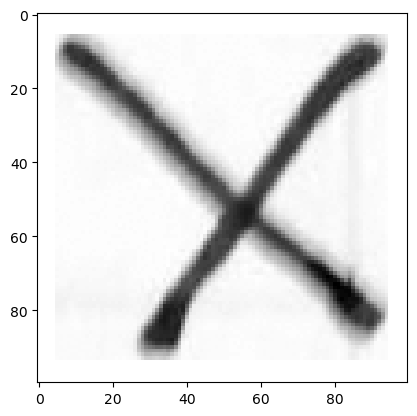

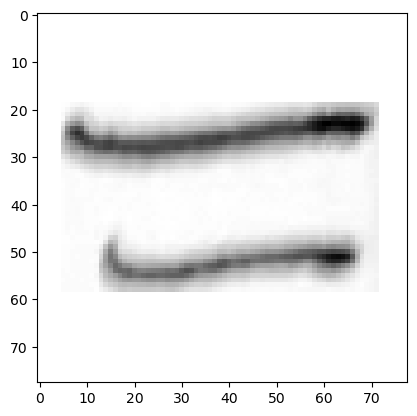

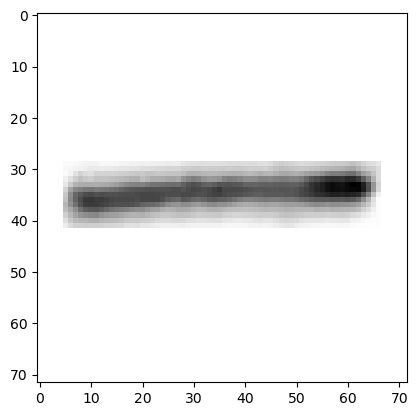

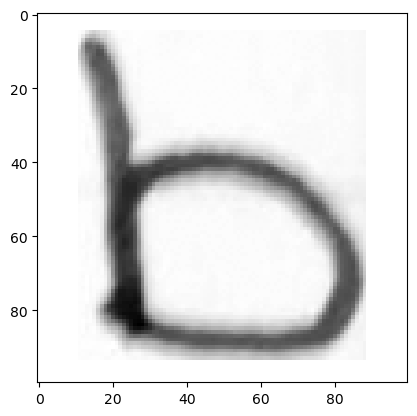

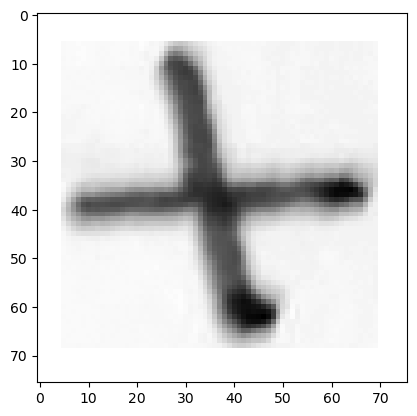

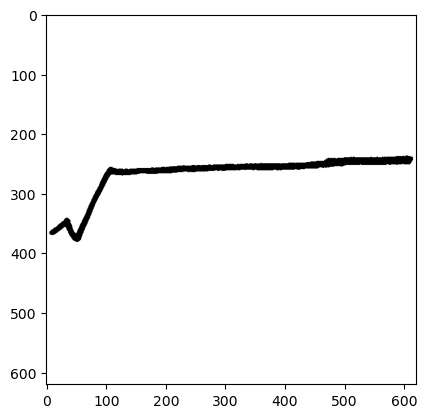

In [925]:
for i in range(6):
    plt.figure()
    plt.imshow(symbs[i], cmap='gray')

In [ ]:
y_classes

In [859]:
import cv2

In [884]:
img_file = '../test_math.png'

img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY)
ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

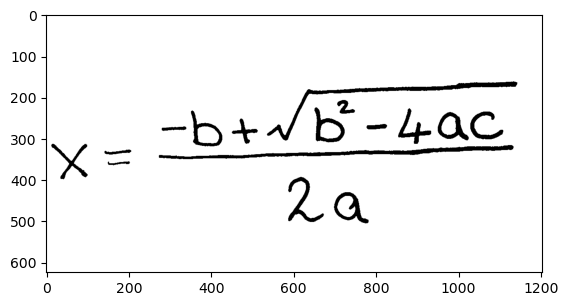

In [885]:
fig, ax = plt.subplots()

ax.imshow(thresh, cmap='gray')

In [872]:
thresh.shape

(624, 1204)